In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.constants import g

In [2]:
WIDTH = 1600
HEIGHT = 1000

AIRCRAFT_SIZE = 24
COLLISION_RADIUS = 2 * AIRCRAFT_SIZE
GOAL_RADIUS = 6 * AIRCRAFT_SIZE
SAFE_DISTANCE = 4 * COLLISION_RADIUS

PLAYER_X = COLLISION_RADIUS
PLAYER_Y = HEIGHT / 2

GOAL_X = WIDTH - GOAL_RADIUS
GOAL_Y = HEIGHT / 2

# KINEMATICS CONSTANTS
AIRSPEED = 200
ACC_LAT_LIMIT = 20 * g

In [3]:
simulation_data_file = "../gym_ACAS2D/models/logs/baseline_ACAS2D_PPO_11_100.csv"
simulation = pd.read_csv(simulation_data_file)
simulation.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Episode        100 non-null    int64  
 1   Outcome        100 non-null    object 
 2   Total Reward   100 non-null    float64
 3   Time Steps     100 non-null    int64  
 4   Path           100 non-null    object 
 5   Traffic Paths  100 non-null    object 
dtypes: float64(1), int64(2), object(3)
memory usage: 4.8+ KB


In [4]:
simulation.head()

,Episode,Outcome,Total Reward,Time Steps,Path,Traffic Paths
0,1,Collision,-988.641838,390,"[(48, 500.0), (49.998468716044925, 499.9217517...","[[(1552, 48), (1552, 48), (1550.186920830651, ..."
1,2,Goal,1159.998484,637,"[(48, 500.0), (49.99894800746714, 500.06486033...","[[(1552, 952), (1552, 952), (1550.521736758849..."
2,3,Collision,-996.445383,386,"[(48, 500.0), (49.999350933065585, 499.9490505...","[[(1552, 48), (1552, 48), (1550.223564852914, ..."
3,4,Collision,-999.997756,382,"[(48, 500.0), (49.9983439685915, 500.081371882...","[[(1552, 952), (1552, 952), (1550.274608491244..."
4,5,Collision,-991.830185,391,"[(48, 500.0), (49.999967753918455, 500.0113570...","[[(1552, 48), (1552, 48), (1550.2362649114634,..."


In [5]:
simulation.describe()

,Episode,Total Reward,Time Steps
count,100.000000,100.000000,100.000000
mean,50.500000,-70.775011,494.650000
std,29.011492,1095.686014,122.109933
min,1.000000,-1000.000000,381.000000
25%,25.750000,-999.312557,389.000000
50%,50.500000,-990.805915,398.500000
75%,75.250000,1160.067900,636.250000
max,100.000000,1386.142636,643.000000


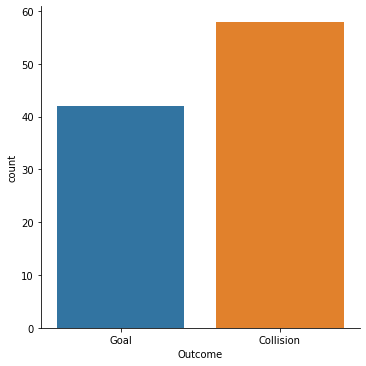

In [6]:
sns.catplot(x="Outcome", data=simulation, order =["Goal", "Collision"], kind="count")

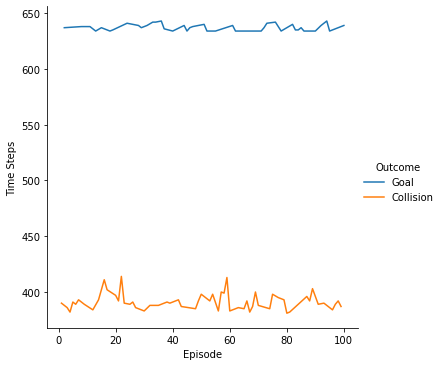

In [7]:
sns.relplot(x="Episode", y="Time Steps", data=simulation, 
            kind ="line", 
            hue="Outcome", 
            hue_order =["Goal", "Collision"])

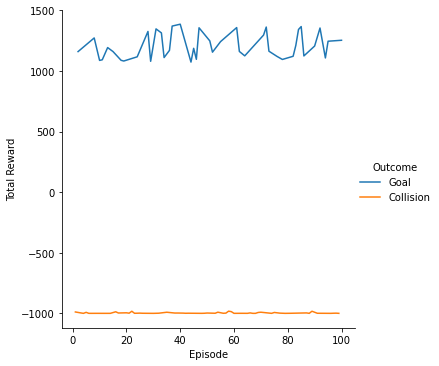

In [8]:
sns.relplot(x="Episode", y="Total Reward", data=simulation, 
            kind ="line", 
            hue="Outcome", 
            hue_order =["Goal", "Collision"])

In [9]:
# Create paths dataframe

import ast

paths_df = pd.DataFrame()

e_values, o_values, x_values, y_values = [], [], [], []
for index, row in simulation.iterrows():
    for (x, y) in ast.literal_eval(row["Path"]):
        e_values.append(row["Episode"])
        o_values.append(row["Outcome"])
        x_values.append(x)
        y_values.append(-y)

paths_df["Episode"] = e_values
paths_df["Outcome"] = o_values
paths_df["x"] = x_values
paths_df["y"] = y_values

In [10]:
paths_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49465 entries, 0 to 49464
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Episode  49465 non-null  int64  
 1   Outcome  49465 non-null  object 
 2   x        49465 non-null  float64
 3   y        49465 non-null  float64
dtypes: float64(2), int64(1), object(1)
memory usage: 1.5+ MB


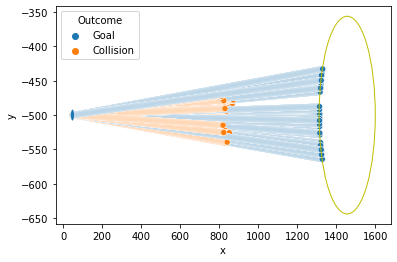

In [11]:
# Agent trajectories

fig, ax = plt.subplots()

sns.scatterplot(x="x", y="y", hue="Outcome", hue_order=["Goal", "Collision"], data=paths_df, ax=ax)

player = plt.Circle((PLAYER_X, -PLAYER_Y), 8)
ax.add_patch(player)

goal = plt.Circle((GOAL_X, -GOAL_Y), GOAL_RADIUS, color='y', fill=False)
ax.add_patch(goal)

In [12]:
t_paths_df = pd.DataFrame()

e_values, o_values, t_values, x_values, y_values = [], [], [], [], []
for index, row in simulation.iterrows():
    t_paths = ast.literal_eval(row["Traffic Paths"])
    for n in range(len(t_paths)):
        for (x, y) in t_paths[n]:
            e_values.append(row["Episode"])
            o_values.append(row["Outcome"])
            t_values.append(n)
            x_values.append(x)
            y_values.append(-y)

t_paths_df["Episode"] = e_values
t_paths_df["Outcome"] = o_values
t_paths_df["Traffic Aircraft"] = t_values
t_paths_df["x"] = x_values
t_paths_df["y"] = y_values

t_paths_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49465 entries, 0 to 49464
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Episode           49465 non-null  int64  
 1   Outcome           49465 non-null  object 
 2   Traffic Aircraft  49465 non-null  int64  
 3   x                 49465 non-null  float64
 4   y                 49465 non-null  float64
dtypes: float64(2), int64(2), object(1)
memory usage: 1.9+ MB


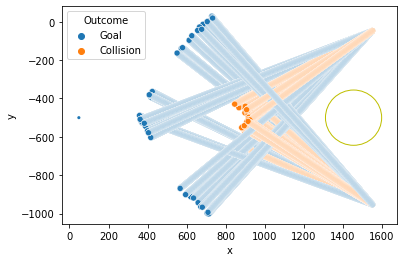

In [13]:
# Traffic trajectories

fig, ax = plt.subplots()

sns.scatterplot(x="x", y="y", hue="Outcome", hue_order=["Goal", "Collision"], data=t_paths_df, ax=ax)

player = plt.Circle((PLAYER_X, -PLAYER_Y), 8)
ax.add_patch(player)

goal = plt.Circle((GOAL_X, -GOAL_Y), GOAL_RADIUS, color='y', fill=False)
ax.add_patch(goal)

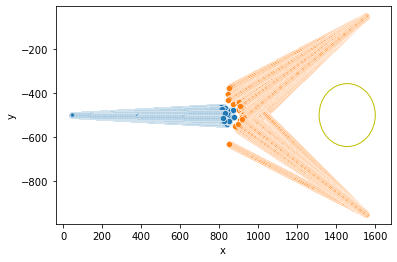

In [14]:
# Collisions

fig, ax = plt.subplots()


sns.scatterplot(x="x", y="y", data=paths_df[paths_df["Outcome"]=="Collision"], ax=ax)
sns.scatterplot(x="x", y="y", data=t_paths_df[t_paths_df["Outcome"]=="Collision"], ax=ax)

player = plt.Circle((PLAYER_X, -PLAYER_Y), 8)
ax.add_patch(player)

goal = plt.Circle((GOAL_X, -GOAL_Y), GOAL_RADIUS, color='y', fill=False)
ax.add_patch(goal)

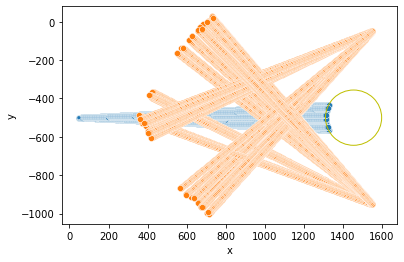

In [15]:
# Goals

fig, ax = plt.subplots()


sns.scatterplot(x="x", y="y", data=paths_df[paths_df["Outcome"]=="Goal"], ax=ax)
sns.scatterplot(x="x", y="y", data=t_paths_df[t_paths_df["Outcome"]=="Goal"], ax=ax)

player = plt.Circle((PLAYER_X, -PLAYER_Y), 8)
ax.add_patch(player)

goal = plt.Circle((GOAL_X, -GOAL_Y), GOAL_RADIUS, color='y', fill=False)
ax.add_patch(goal)

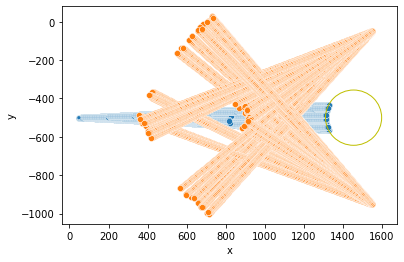

In [16]:
# All encounters

fig, ax = plt.subplots()


sns.scatterplot(x="x", y="y", data=paths_df, ax=ax)
sns.scatterplot(x="x", y="y", data=t_paths_df, ax=ax)

player = plt.Circle((PLAYER_X, -PLAYER_Y), 8)
ax.add_patch(player)

goal = plt.Circle((GOAL_X, -GOAL_Y), GOAL_RADIUS, color='y', fill=False)
ax.add_patch(goal)